In [1]:
#Analyzing the Game of Thrones (GoT) Data for character trends that correlate with the Battle data
#Create a tool with predictive capabilities for Battle outcomes using character trends and house strength/performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

In [3]:
#Tree-Based Models libraries import
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn import utils
from sklearn import preprocessing

In [4]:
battles = pd.read_csv('battles.csv')               #Read in the Battles data
deaths = pd.read_csv('character-deaths.csv')         #Read in the Character Deaths data
preds = pd.read_csv('character-predictions.csv')     #Read in the Character Predictions data

In [5]:
#First look at each of the tables

In [6]:
battles.groupby('region').attacker_king.count().head(10)

region
Beyond the Wall     1
The Crownlands      2
The North          10
The Reach           2
The Riverlands     15
The Stormlands      3
The Westerlands     3
Name: attacker_king, dtype: int64

In [7]:
deaths.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,NaN,NaN,NaN,NaN,1,1,0,0,1,0,0


In [8]:
preds.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [9]:
#See the tables' sizes and column data types
battles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 25 columns):
name                  38 non-null object
year                  38 non-null int64
battle_number         38 non-null int64
attacker_king         36 non-null object
defender_king         35 non-null object
attacker_1            38 non-null object
attacker_2            10 non-null object
attacker_3            3 non-null object
attacker_4            2 non-null object
defender_1            37 non-null object
defender_2            2 non-null object
defender_3            0 non-null float64
defender_4            0 non-null float64
attacker_outcome      37 non-null object
battle_type           37 non-null object
major_death           37 non-null float64
major_capture         37 non-null float64
attacker_size         24 non-null float64
defender_size         19 non-null float64
attacker_commander    37 non-null object
defender_commander    28 non-null object
summer                37 non-null flo

In [10]:
deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 13 columns):
Name                  917 non-null object
Allegiances           917 non-null object
Death Year            305 non-null float64
Book of Death         307 non-null float64
Death Chapter         299 non-null float64
Book Intro Chapter    905 non-null float64
Gender                917 non-null int64
Nobility              917 non-null int64
GoT                   917 non-null int64
CoK                   917 non-null int64
SoS                   917 non-null int64
FfC                   917 non-null int64
DwD                   917 non-null int64
dtypes: float64(4), int64(7), object(2)
memory usage: 93.2+ KB


In [11]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
S.No                 1946 non-null int64
actual               1946 non-null int64
pred                 1946 non-null int64
alive                1946 non-null float64
plod                 1946 non-null float64
name                 1946 non-null object
title                938 non-null object
male                 1946 non-null int64
culture              677 non-null object
dateOfBirth          433 non-null float64
DateoFdeath          444 non-null float64
mother               21 non-null object
father               26 non-null object
heir                 23 non-null object
house                1519 non-null object
spouse               276 non-null object
book1                1946 non-null int64
book2                1946 non-null int64
book3                1946 non-null int64
book4                1946 non-null int64
book5                1946 non-null int64
isAliveMother        21 non

In [12]:
print(battles.isnull().sum().sum(), 
      deaths.isnull().sum().sum(), 
      preds.isnull().sum().sum() )    #sum all missing values in each worksheet

300 1852 22108


In [13]:
#Cleanse Dataframes

In [14]:
#Assess Null Values
deaths = deaths.fillna('None')
preds = preds.fillna('None')
battles = battles.fillna('None')

In [15]:
#Drop unnecessary columns
#character deaths dataframe
deaths = deaths.drop('Death Chapter',axis=1)
deaths = deaths.drop('Book Intro Chapter',axis=1)
#character predictions dataframe
preds = preds.drop('S.No',axis=1)
preds = preds.drop('actual',axis=1)
preds = preds.drop('pred',axis=1)
preds = preds.drop('alive',axis=1)
preds = preds.drop('plod',axis=1)
preds = preds.drop('mother',axis=1)
preds = preds.drop('father',axis=1)
preds = preds.drop('heir',axis=1)
preds = preds.drop('spouse',axis=1)
preds = preds.drop('isAliveMother',axis=1)
preds = preds.drop('isAliveFather',axis=1)
preds = preds.drop('isAliveHeir',axis=1)
preds = preds.drop('isAliveSpouse',axis=1)
preds = preds.drop('numDeadRelations',axis=1)
preds = preds.drop('boolDeadRelations',axis=1)
#battles dataframe
battles = battles.drop('defender_3',axis=1)
battles = battles.drop('defender_4',axis=1)
battles = battles.drop('attacker_commander',axis=1)
battles = battles.drop('defender_commander',axis=1)
battles = battles.drop('note',axis=1)

In [16]:
#Clean column names
deaths.columns = ['Name','House','Death_Year','Book_Death','Gender','Nobility','b1','b2','b3','b4','b5']
preds.columns = ['Name','Title','Gender','Culture','Birth_Year','Death_Year','House','b1','b2','b3','b4','b5','Married','Nobility','Age','Popular','Popularity','Alive']

In [17]:
preds.head()

,Name,Title,Gender,Culture,Birth_Year,Death_Year,House,b1,b2,b3,b4,b5,Married,Nobility,Age,Popular,Popularity,Alive
0,Viserys II Targaryen,None,1,None,None,None,None,0,0,0,0,0,0,0,None,1,0.605351,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208,None,House Frey,1,1,1,1,1,1,1,97,1,0.896321,1
2,Addison Hill,Ser,1,None,None,None,House Swyft,0,0,0,1,0,0,1,None,0,0.267559,1
3,Aemma Arryn,Queen,0,None,82,105,House Arryn,0,0,0,0,0,1,1,23,0,0.183946,0
4,Sylva Santagar,Greenstone,0,Dornish,276,None,House Santagar,0,0,0,1,0,1,1,29,0,0.043478,1


In [18]:
deaths.head()

,Name,House,Death_Year,Book_Death,Gender,Nobility,b1,b2,b3,b4,b5
0,Addam Marbrand,Lannister,None,None,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299,3,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,None,None,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300,5,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,None,None,1,1,0,0,1,0,0


In [19]:
#Check for inconsistency in all columns with an object datatype
#Check House column of deaths dataframe
deaths.groupby('House').Name.count()

House
Arryn               23
Baratheon           56
Greyjoy             51
House Arryn          7
House Baratheon      8
House Greyjoy       24
House Lannister     21
House Martell       12
House Stark         35
House Targaryen     19
House Tully          8
House Tyrell        11
Lannister           81
Martell             25
Night's Watch      116
None               253
Stark               73
Targaryen           17
Tully               22
Tyrell              15
Wildling            40
Name: Name, dtype: int64

In [20]:
#replace house names in deaths dataframe
deaths.loc[deaths.House == 'Arryn', 'House'] = 'House Arryn'
deaths.loc[deaths.House == 'Baratheon', 'House'] = 'House Baratheon'
deaths.loc[deaths.House == 'Greyjoy', 'House'] = 'House Greyjoy'
deaths.loc[deaths.House == 'Lannister', 'House'] = 'House Lannister'
deaths.loc[deaths.House == 'Martell', 'House'] = 'House Martell'
deaths.loc[deaths.House == 'Stark', 'House'] = 'House Stark'
deaths.loc[deaths.House == 'Targaryen', 'House'] = 'House Targaryen'
deaths.loc[deaths.House == 'Tully', 'House'] = 'House Tully'
deaths.loc[deaths.House == 'Tyrell', 'House'] = 'House Tyrell'

In [21]:
#Check House column of predictions dataframe
preds.groupby('House').Name.count()

House
Alchemists' Guild                   7
Antler Men                          1
Band of Nine                        1
Black Ears                          2
Blacks                              4
Brave Companions                   12
Brotherhood Without Banners         6
Brotherhood without Banners         1
Brotherhood without banners        11
Burned Men                          2
Chataya's brothel                   5
Citadel                             1
City Watch of King's Landing        1
Company of the Cat                  1
Drowned men                         5
Faceless Men                        2
Faith of the Seven                 17
Golden Company                      2
Good Masters                        2
Graces                              1
Happy Port                          4
House Allyrion                      3
House Ambrose                       4
House Arryn                        16
House Ashford                       5
House Baelish                       7
House 

In [22]:
#replace House names in predictions dataframe
preds.loc[preds.House == 'Brotherhood without Banners', 'House'] = 'Brotherhood Without Banners'
preds.loc[preds.House == 'Brotherhood without banners', 'House'] = 'Brotherhood Without Banners'
preds.loc[preds.House == 'brotherhood without banners', 'House'] = 'Brotherhood Without Banners'
preds.loc[preds.House == 'House Dayne of High Hermitage', 'House'] = 'House Dayne'
preds.loc[preds.House == 'House Bolton of the Dreadfort', 'House'] = 'House Bolton'
preds.loc[preds.House == 'House Brune of Brownhollow', 'House'] = 'House Brune'
preds.loc[preds.House == 'House Brune of the Dyre Den', 'House'] = 'House Brune'
preds.loc[preds.House == "House Baratheon of King's Landing", 'House'] = 'House Baratheon'
preds.loc[preds.House == "House Baratheon of Dragonstone", 'House'] = 'House Baratheon'
preds.loc[preds.House == 'House Farwynd of the Lonely Light', 'House'] = 'House Farwynd'
preds.loc[preds.House == "House Flint of Widow's Watch", 'House'] = 'House Flint'
preds.loc[preds.House == 'House Fossoway of Cider Hall', 'House'] = 'House Fossoway'
preds.loc[preds.House == 'House Fossoway of New Barrel', 'House'] = 'House Fossoway'
preds.loc[preds.House == 'House Frey of Riverrun', 'House'] = 'House Frey'
preds.loc[preds.House == 'House Goodbrother of Shatterstone', 'House'] = 'House Goodbrother'
preds.loc[preds.House == 'House Harlaw of Grey Garden', 'House'] = 'House Harlaw'
preds.loc[preds.House == 'House Harlaw of Harlaw Hall', 'House'] = 'House Harlaw'
preds.loc[preds.House == 'House Harlaw of Harridan Hill', 'House'] = 'House Harlaw'
preds.loc[preds.House == 'House Harlaw of the Tower of Glimmering', 'House'] = 'House Harlaw'
preds.loc[preds.House == 'House Kenning of Harlaw', 'House'] = 'House Kenning'
preds.loc[preds.House == 'House Kenning of Kayce', 'House'] = 'House Kenning'
preds.loc[preds.House == 'House Lannister of Casterly Rock', 'House'] = 'House Lannister'
preds.loc[preds.House == 'House Lannister of Lannisport', 'House'] = 'House Lannister'
preds.loc[preds.House == 'House Nymeros Martell', 'House'] = 'House Martell'
preds.loc[preds.House == 'House of Galare', 'House'] = 'House Galare'
preds.loc[preds.House == 'House of Ghazeen', 'House'] = 'House Ghazeen'
preds.loc[preds.House == 'House of Kandaq', 'House'] = 'House Kandaq'
preds.loc[preds.House == 'House of Loraq', 'House'] = 'House Loraq'
preds.loc[preds.House == 'House of Merreq', 'House'] = 'House Merreq'
preds.loc[preds.House == 'House of Pahl', 'House'] = 'House Pahl'
preds.loc[preds.House == 'House of Reznak', 'House'] = 'House Reznak'
preds.loc[preds.House == 'House Royce of the Gates of the Moon', 'House'] = 'House Royce'
preds.loc[preds.House == 'House Shett of Gull Tower', 'House'] = 'House Shett'
preds.loc[preds.House == 'House Tyrell of Brightwater Keep', 'House'] = 'House Tyrell'
preds.loc[preds.House == 'House Vance of Atranta', 'House'] = 'House Vance'
preds.loc[preds.House == "House Vance of Wayfarer's Rest", 'House'] = 'House Vance'
preds.loc[preds.House == 'House Tyrell of Brightwater Keep', 'House'] = 'House Tyrell'
preds.loc[preds.House == 'wildling', 'House'] = 'Wildling'

In [23]:
#Check Culture column of predictions dataframe
preds.groupby('Culture').Name.count()

Culture
Andal                     1
Andals                    1
Asshai                    2
Asshai'i                  1
Astapor                   1
Astapori                  4
Braavos                   1
Braavosi                 42
Crannogmen                4
Dorne                     2
Dornish                  25
Dornishmen               14
Dothraki                 23
First Men                 3
Free Folk                51
Free folk                11
Ghiscari                 25
Ghiscaricari              1
Ibbenese                  1
Ironborn                112
Ironmen                   5
Lhazareen                 2
Lhazarene                 1
Lysene                    4
Lyseni                    3
Meereen                   1
Meereenese                3
Myrish                    3
Naathi                    1
None                   1269
                       ... 
Qarth                     1
Qartheen                  6
Qohor                     2
Reach                    16
Reachmen    

In [24]:
#replace Culture names in predictions dataframe
preds.loc[preds.Culture == 'Andals', 'Culture'] = 'Andal'
preds.loc[preds.Culture == 'Asshai', 'Culture'] = "Asshai'i"
preds.loc[preds.Culture == 'Astapor', 'Culture'] = 'Astapori'
preds.loc[preds.Culture == 'Braavos', 'Culture'] = 'Braavosi'
preds.loc[preds.Culture == 'Dorne', 'Culture'] = 'Dornish'
preds.loc[preds.Culture == 'Dornishmen', 'Culture'] = 'Dornish'
preds.loc[preds.Culture == 'Free folk', 'Culture'] = 'Free Folk'
preds.loc[preds.Culture == 'Ghiscaricari', 'Culture'] = 'Ghiscari'
preds.loc[preds.Culture == 'Ironmen', 'Culture'] = 'Ironborn'
preds.loc[preds.Culture == 'Lhazareen', 'Culture'] = 'Lhazarene'
preds.loc[preds.Culture == 'Lysene', 'Culture'] = 'Lyseni'
preds.loc[preds.Culture == 'Meereen', 'Culture'] = 'Meereenese'
preds.loc[preds.Culture == 'Qarth', 'Culture'] = 'Qartheen'
preds.loc[preds.Culture == 'Reach', 'Culture'] = 'Reachmen'
preds.loc[preds.Culture == 'Riverlands', 'Culture'] = 'Rivermen'
preds.loc[preds.Culture == 'Stormlands', 'Culture'] = 'Stormlander'
preds.loc[preds.Culture == 'Summer Islands', 'Culture'] = 'Summer Islander'
preds.loc[preds.Culture == 'Summer Isles', 'Culture'] = 'Summer Islander'
preds.loc[preds.Culture == 'The Reach', 'Culture'] = 'Reachmen'
preds.loc[preds.Culture == 'Vale', 'Culture'] = 'Valemen'
preds.loc[preds.Culture == 'Vale mountain clans', 'Culture'] = 'Valemen'
preds.loc[preds.Culture == 'Westerlands', 'Culture'] = 'Westermen'
preds.loc[preds.Culture == 'Westerman', 'Culture'] = 'Westermen'
preds.loc[preds.Culture == 'Westeros', 'Culture'] = 'Westermen'
preds.loc[preds.Culture == 'Wildlings', 'Culture'] = 'Wildling'
preds.loc[preds.Culture == 'westermen', 'Culture'] = 'Westermen'
preds.loc[preds.Culture == 'ironborn', 'Culture'] = 'Ironborn'
preds.loc[preds.Culture == 'northmen', 'Culture'] = 'Northmen'
preds.loc[preds.Culture == 'Northern mountain clans', 'Culture'] = 'Northmen'
preds.loc[preds.Culture == 'Norvos', 'Culture'] = 'Norvoshi'
preds.loc[preds.Culture == 'free folk', 'Culture'] = 'Free Folk'

In [25]:
#Check Attacking King column of battles dataframe
battles.groupby('attacker_king').name.count()

attacker_king
Balon/Euron Greyjoy          7
Joffrey/Tommen Baratheon    14
None                         2
Robb Stark                  10
Stannis Baratheon            5
Name: name, dtype: int64

In [26]:
#replace Attacking King names in battles dataframe
battles.loc[battles.attacker_king == 'Balon/Euron Greyjoy', 'attacker_king'] = 'Balon Greyjoy'
battles.loc[battles.attacker_king == 'Joffrey/Tommen Baratheon', 'attacker_king'] = 'Joffrey Baratheon'

In [27]:
#Check Defending King column of battles dataframe
battles.groupby('defender_king').name.count()

defender_king
Balon/Euron Greyjoy          4
Joffrey/Tommen Baratheon    13
Mance Rayder                 1
None                         3
Renly Baratheon              1
Robb Stark                  14
Stannis Baratheon            2
Name: name, dtype: int64

In [28]:
#replace Defending King names in battles dataframe
battles.loc[battles.defender_king == 'Balon/Euron Greyjoy', 'defender_king'] = 'Balon Greyjoy'
battles.loc[battles.defender_king == 'Joffrey/Tommen Baratheon', 'defender_king'] = 'Joffrey Baratheon'

In [29]:
#Check Primary Attacking House column of battles dataframe
battles.groupby('attacker_1').name.count()

attacker_1
Baratheon                      6
Bolton                         2
Bracken                        1
Brave Companions               1
Brotherhood without Banners    1
Darry                          1
Free folk                      1
Frey                           2
Greyjoy                        7
Lannister                      8
Stark                          8
Name: name, dtype: int64

In [30]:
#replace Primary Attacking House names in battles dataframe
battles.loc[battles.attacker_1 == 'Baratheon', 'attacker_1'] = 'House Baratheon'
battles.loc[battles.attacker_1 == 'Bolton', 'attacker_1'] = 'House Bolton'
battles.loc[battles.attacker_1 == 'Bracken', 'attacker_1'] = 'House Bracken'
battles.loc[battles.attacker_1 == 'Brotherhood without Banners', 'attacker_1'] = 'Brotherhood Without Banners'
battles.loc[battles.attacker_1 == 'Darry', 'attacker_1'] = 'House Darry'
battles.loc[battles.attacker_1 == 'Free folk', 'attacker_1'] = 'Free Folk'
battles.loc[battles.attacker_1 == 'Frey', 'attacker_1'] = 'House Frey'
battles.loc[battles.attacker_1 == 'Greyjoy', 'attacker_1'] = 'House Greyjoy'
battles.loc[battles.attacker_1 == 'Lannister', 'attacker_1'] = 'House Lannister'
battles.loc[battles.attacker_1 == 'Stark', 'attacker_1'] = 'House Stark'

In [31]:
#Check Support Attacking House 1 column of battles dataframe
battles.groupby('attacker_2').name.count()

attacker_2
Bolton        1
Frey          1
Greyjoy       1
Karstark      2
Lannister     1
None         28
Thenns        1
Tully         3
Name: name, dtype: int64

In [32]:
#replace Support Attacking House 1 names in battles dataframe
battles.loc[battles.attacker_2 == 'Bolton', 'attacker_2'] = 'House Bolton'
battles.loc[battles.attacker_2 == 'Greyjoy', 'attacker_2'] = 'House Greyjoy'
battles.loc[battles.attacker_2 == 'Karstark', 'attacker_2'] = 'House Karstark'
battles.loc[battles.attacker_2 == 'Lannister', 'attacker_2'] = 'House Lannister'
battles.loc[battles.attacker_2 == 'Thenns', 'attacker_2'] = 'House Thenns'
battles.loc[battles.attacker_2 == 'Tully', 'attacker_2'] = 'House Tully'

In [33]:
#Check Support Attacking House 2 column of battles dataframe
battles.groupby('attacker_3').name.count()

attacker_3
Giants      1
Mormont     2
None       35
Name: name, dtype: int64

In [34]:
#replace Support Attacking House 2 names in battles dataframe
battles.loc[battles.attacker_3 == 'Mormont', 'attacker_3'] = 'House Mormont'

In [35]:
#Check Support Attacking House 3 column of battles dataframe
battles.groupby('attacker_4').name.count()

attacker_4
Glover     2
None      36
Name: name, dtype: int64

In [36]:
#replace Support Attacking House 3 names in battles dataframe
battles.loc[battles.attacker_4 == 'Glover', 'attacker_4'] = 'House Glover'

In [37]:
#Check Primary Attacking House column of battles dataframe
battles.groupby('defender_1').name.count()

defender_1
Baratheon           4
Blackwood           1
Bolton              1
Brave Companions    2
Darry               1
Greyjoy             3
Lannister           9
Mallister           1
Night's Watch       1
None                1
Stark               8
Tully               4
Tyrell              2
Name: name, dtype: int64

In [38]:
#replace Primary Defending House names in battles dataframe
battles.loc[battles.defender_1 == 'Baratheon', 'defender_1'] = 'House Baratheon'
battles.loc[battles.defender_1 == 'Bolton', 'defender_1'] = 'House Bolton'
battles.loc[battles.defender_1 == 'Darry', 'defender_1'] = 'House Darry'
battles.loc[battles.defender_1 == 'Greyjoy', 'defender_1'] = 'House Greyjoy'
battles.loc[battles.defender_1 == 'Lannister', 'defender_1'] = 'House Lannister'
battles.loc[battles.defender_1 == 'Mallister', 'defender_1'] = 'House Mallister'
battles.loc[battles.defender_1 == 'Stark', 'defender_1'] = 'House Stark'
battles.loc[battles.defender_1 == 'Tully', 'defender_1'] = 'House Tully'
battles.loc[battles.defender_1 == 'Tyrell', 'defender_1'] = 'House Tyrell'

In [39]:
#Check Support Defending House column of battles dataframe
battles.groupby('defender_2').name.count()

defender_2
Baratheon     1
Frey          1
None         36
Name: name, dtype: int64

In [40]:
#replace Support Defending House names in battles dataframe
battles.loc[battles.defender_2 == 'Baratheon', 'defender_2'] = 'House Baratheon'
battles.loc[battles.defender_2 == 'Frey', 'defender_2'] = 'House Frey'

In [41]:
#Merge character information dataframes
char = pd.merge(preds, deaths, on='Name', how='outer')
char.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2014 entries, 0 to 2013
Data columns (total 28 columns):
Name            2014 non-null object
Title           1947 non-null object
Gender_x        1947 non-null float64
Culture         1947 non-null object
Birth_Year      1947 non-null object
Death_Year_x    1947 non-null object
House_x         1947 non-null object
b1_x            1947 non-null float64
b2_x            1947 non-null float64
b3_x            1947 non-null float64
b4_x            1947 non-null float64
b5_x            1947 non-null float64
Married         1947 non-null float64
Nobility_x      1947 non-null float64
Age             1947 non-null object
Popular         1947 non-null float64
Popularity      1947 non-null float64
Alive           1947 non-null float64
House_y         917 non-null object
Death_Year_y    917 non-null object
Book_Death      917 non-null object
Gender_y        917 non-null float64
Nobility_y      917 non-null float64
b1_y            917 non-null float

In [42]:
#Attend to NaN values
char = char.fillna('None')
char.head()

,Name,Title,Gender_x,Culture,Birth_Year,Death_Year_x,House_x,b1_x,b2_x,b3_x,...,House_y,Death_Year_y,Book_Death,Gender_y,Nobility_y,b1_y,b2_y,b3_y,b4_y,b5_y
0,Viserys II Targaryen,None,1,None,None,None,None,0,0,0,...,None,None,None,None,None,None,None,None,None,None
1,Walder Frey,Lord of the Crossing,1,Rivermen,208,None,House Frey,1,1,1,...,None,None,None,1,1,1,0,1,0,0
2,Addison Hill,Ser,1,None,None,None,House Swyft,0,0,0,...,None,None,None,None,None,None,None,None,None,None
3,Aemma Arryn,Queen,0,None,82,105,House Arryn,0,0,0,...,None,None,None,None,None,None,None,None,None,None
4,Sylva Santagar,Greenstone,0,Dornish,276,None,House Santagar,0,0,0,...,House Martell,None,None,0,1,0,0,0,1,0


In [43]:
#Factorize and convert datatypes to numeric dataframes
#Character dataframe
#char.Culture  = pd.factorize(char.Culture)[0]
char.Gender_x = pd.to_numeric(char.Gender_x, errors='coerce')
char.Gender_y = pd.to_numeric(char.Gender_y, errors='coerce')
char.Birth_Year = pd.to_numeric(char.Birth_Year, errors='coerce')
char.Death_Year_x = pd.to_numeric(char.Death_Year_x, errors='coerce')
char.Death_Year_y = pd.to_numeric(char.Death_Year_y, errors='coerce')
char.b1_x = pd.to_numeric(char.b1_x, errors='coerce')
char.b2_x = pd.to_numeric(char.b2_x, errors='coerce')
char.b3_x = pd.to_numeric(char.b3_x, errors='coerce')
char.b4_x = pd.to_numeric(char.b4_x, errors='coerce')
char.b5_x = pd.to_numeric(char.b5_x, errors='coerce')
char.b1_y = pd.to_numeric(char.b1_y, errors='coerce')
char.b2_y = pd.to_numeric(char.b2_y, errors='coerce')
char.b3_y = pd.to_numeric(char.b3_y, errors='coerce')
char.b4_y = pd.to_numeric(char.b4_y, errors='coerce')
char.b5_y = pd.to_numeric(char.b5_y, errors='coerce')
char.Married = pd.to_numeric(char.Married, errors='coerce')
char.Nobility_x = pd.to_numeric(char.Nobility_x, errors='coerce')
char.Nobility_y = pd.to_numeric(char.Nobility_y, errors='coerce')
char.Age = pd.to_numeric(char.Age, errors='coerce')
char.Popular = pd.to_numeric(char.Popular, errors='coerce')
char.Popularity = pd.to_numeric(char.Popularity, errors='coerce')
char.Alive = pd.to_numeric(char.Alive, errors='coerce')
char.Book_Death = pd.to_numeric(char.Book_Death, errors='coerce')
#Battles dataframe
battles.attacker_outcome = pd.factorize(battles.attacker_outcome)[0]
battles.battle_type = pd.factorize(battles.battle_type)[0]
#battles.location = pd.factorize(battles.location)[0]
#battles.region = pd.factorize(battles.region)[0]
battles.major_death = pd.to_numeric(battles.major_death, errors='coerce')
battles.major_capture = pd.to_numeric(battles.major_capture, errors='coerce')
battles.attacker_size = pd.to_numeric(battles.attacker_size, errors='coerce')
battles.defender_size = pd.to_numeric(battles.defender_size, errors='coerce')
battles.summer = pd.to_numeric(battles.summer, errors='coerce')

In [44]:
#Attend to NaN values
char = char.fillna('None')
char.head()

,Name,Title,Gender_x,Culture,Birth_Year,Death_Year_x,House_x,b1_x,b2_x,b3_x,...,House_y,Death_Year_y,Book_Death,Gender_y,Nobility_y,b1_y,b2_y,b3_y,b4_y,b5_y
0,Viserys II Targaryen,None,1,None,None,None,None,0,0,0,...,None,None,None,None,None,None,None,None,None,None
1,Walder Frey,Lord of the Crossing,1,Rivermen,208,None,House Frey,1,1,1,...,None,None,None,1,1,1,0,1,0,0
2,Addison Hill,Ser,1,None,None,None,House Swyft,0,0,0,...,None,None,None,None,None,None,None,None,None,None
3,Aemma Arryn,Queen,0,None,82,105,House Arryn,0,0,0,...,None,None,None,None,None,None,None,None,None,None
4,Sylva Santagar,Greenstone,0,Dornish,276,None,House Santagar,0,0,0,...,House Martell,None,None,0,1,0,0,0,1,0


In [45]:
#Merge columns where data is missing
char.loc[char.House_x == 'None', 'House_x'] = char.House_y
char.loc[char.Gender_x == 'None', 'Gender_x'] = char.Gender_y
char.loc[char.Death_Year_x == 'None', 'Death_Year_x'] = char.Death_Year_y
char.loc[char.b1_x == 'None', 'b1_x'] = char.b1_y
char.loc[char.b2_x == 'None', 'b2_x'] = char.b2_y
char.loc[char.b3_x == 'None', 'b3_x'] = char.b3_y
char.loc[char.b4_x == 'None', 'b4_x'] = char.b4_y
char.loc[char.b5_x == 'None', 'b5_x'] = char.b5_y
char.loc[char.Nobility_x == 'None', 'Nobility_x'] = char.Nobility_y

In [46]:
#Drop redundant columns
char = char.drop('House_y',axis=1)
char = char.drop('Gender_y',axis=1)
char = char.drop('Death_Year_y',axis=1)
char = char.drop('b1_y',axis=1)
char = char.drop('b2_y',axis=1)
char = char.drop('b3_y',axis=1)
char = char.drop('b4_y',axis=1)
char = char.drop('b5_y',axis=1)
char = char.drop('Nobility_y',axis=1)

In [47]:
#Clean column names
char.columns = ['Name','Title','Gender','Culture','Birth_Year','Death_Year','House','b1','b2','b3','b4','b5','Married','Nobility','Age','Popular','Popularity','Alive','Book_Death']

In [48]:
#Wrangle and organize tables to focus on the Characters and their relationships to define house structure

In [49]:
char.head()

,Name,Title,Gender,Culture,Birth_Year,Death_Year,House,b1,b2,b3,b4,b5,Married,Nobility,Age,Popular,Popularity,Alive,Book_Death
0,Viserys II Targaryen,None,1,None,None,None,None,0,0,0,0,0,0,0,None,1,0.605351,0,None
1,Walder Frey,Lord of the Crossing,1,Rivermen,208,None,House Frey,1,1,1,1,1,1,1,97,1,0.896321,1,None
2,Addison Hill,Ser,1,None,None,None,House Swyft,0,0,0,1,0,0,1,None,0,0.267559,1,None
3,Aemma Arryn,Queen,0,None,82,105,House Arryn,0,0,0,0,0,1,1,23,0,0.183946,0,None
4,Sylva Santagar,Greenstone,0,Dornish,276,None,House Santagar,0,0,0,1,0,1,1,29,0,0.0434783,1,None


In [50]:
age = char[char.Age != 'None']
#age.info()

In [51]:
char.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2014 entries, 0 to 2013
Data columns (total 19 columns):
Name          2014 non-null object
Title         2014 non-null object
Gender        2014 non-null object
Culture       2014 non-null object
Birth_Year    2014 non-null object
Death_Year    2014 non-null object
House         2014 non-null object
b1            2014 non-null object
b2            2014 non-null object
b3            2014 non-null object
b4            2014 non-null object
b5            2014 non-null object
Married       2014 non-null object
Nobility      2014 non-null object
Age           2014 non-null object
Popular       2014 non-null object
Popularity    2014 non-null object
Alive         2014 non-null object
Book_Death    2014 non-null object
dtypes: object(19)
memory usage: 394.7+ KB


In [52]:
char.Nobility  = char.Nobility.astype('float64')
char.Gender  = char.Gender.astype('float64')
pop = char[char.Popular != 'None']
pop.Popular  = pop.Popular.astype('float64')
pop.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Name,Title,Gender,Culture,Birth_Year,Death_Year,House,b1,b2,b3,b4,b5,Married,Nobility,Age,Popular,Popularity,Alive,Book_Death
0,Viserys II Targaryen,None,1.0,None,None,None,None,0,0,0,0,0,0,0.0,None,1.0,0.605351,0,None
1,Walder Frey,Lord of the Crossing,1.0,Rivermen,208,None,House Frey,1,1,1,1,1,1,1.0,97,1.0,0.896321,1,None
2,Addison Hill,Ser,1.0,None,None,None,House Swyft,0,0,0,1,0,0,1.0,None,0.0,0.267559,1,None
3,Aemma Arryn,Queen,0.0,None,82,105,House Arryn,0,0,0,0,0,1,1.0,23,0.0,0.183946,0,None
4,Sylva Santagar,Greenstone,0.0,Dornish,276,None,House Santagar,0,0,0,1,0,1,1.0,29,0.0,0.0434783,1,None


In [53]:
battles.groupby('attacker_1')['attacker_2'].count()

attacker_1
Brave Companions               1
Brotherhood Without Banners    1
Free Folk                      1
House Baratheon                6
House Bolton                   2
House Bracken                  1
House Darry                    1
House Frey                     2
House Greyjoy                  7
House Lannister                8
House Stark                    8
Name: attacker_2, dtype: int64

In [54]:
battles.head(30)

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,defender_2,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,summer,location,region
0,Battle of the Golden Tooth,298,1,Joffrey Baratheon,Robb Stark,House Lannister,None,None,None,House Tully,None,0,0,1.0,0.0,15000.0,4000.0,1.0,Golden Tooth,The Westerlands
1,Battle at the Mummer's Ford,298,2,Joffrey Baratheon,Robb Stark,House Lannister,None,None,None,House Baratheon,None,0,1,1.0,0.0,NaN,120.0,1.0,Mummer's Ford,The Riverlands
2,Battle of Riverrun,298,3,Joffrey Baratheon,Robb Stark,House Lannister,None,None,None,House Tully,None,0,0,0.0,1.0,15000.0,10000.0,1.0,Riverrun,The Riverlands
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey Baratheon,House Stark,None,None,None,House Lannister,None,1,0,1.0,1.0,18000.0,20000.0,1.0,Green Fork,The Riverlands
4,Battle of the Whispering Wood,298,5,Robb Stark,Joffrey Baratheon,House Stark,House Tully,None,None,House Lannister,None,0,1,1.0,1.0,1875.0,6000.0,1.0,Whispering Wood,The Riverlands
5,Battle of the Camps,298,6,Robb Stark,Joffrey Baratheon,House Stark,House Tully,None,None,House Lannister,None,0,1,0.0,0.0,6000.0,12625.0,1.0,Riverrun,The Riverlands
6,Sack of Darry,298,7,Joffrey Baratheon,Robb Stark,House Lannister,None,None,None,House Darry,None,0,0,0.0,0.0,NaN,NaN,1.0,Darry,The Riverlands
7,Battle of Moat Cailin,299,8,Balon Greyjoy,Robb Stark,House Greyjoy,None,None,None,House Stark,None,0,0,0.0,0.0,NaN,NaN,1.0,Moat Cailin,The North
8,Battle of Deepwood Motte,299,9,Balon Greyjoy,Robb Stark,House Greyjoy,None,None,None,House Stark,None,0,2,0.0,0.0,1000.0,NaN,1.0,Deepwood Motte,The North
9,Battle of the Stony Shore,299,10,Balon Greyjoy,Robb Stark,House Greyjoy,None,None,None,House Stark,None,0,1,0.0,0.0,264.0,NaN,1.0,Stony Shore,The North


In [55]:
battles.attacker_size = battles.attacker_size.fillna("0")
battles.defender_size = battles.defender_size.fillna("0")
battles.loc[battles.attacker_size == '0', 'attacker_size'] = battles.defender_size
battles.loc[battles.defender_size == '0', 'defender_size'] = battles.attacker_size
battles.attacker_size = battles.attacker_size.astype('float64')
battles.defender_size = battles.defender_size.astype('float64')

In [56]:
House = pd.DataFrame()
House['NumChar'] = char.groupby('House').Name.count()
House['AvgPop'] = pop.groupby('House')['Popular'].mean()
House['NumNoble'] = char.groupby('House').Nobility.sum()
House['BattlesAtt'] = battles.groupby('attacker_1').battle_number.count()
House['NumSupAtt'] = battles.groupby('attacker_1').attacker_2.count()
House['BattlesDef'] = battles.groupby('defender_1').battle_number.count()
House['NumSupDef'] = battles.groupby('defender_1').defender_2.count()
House['NumBattles'] = House.BattlesAtt + House.BattlesDef 
House['NumRegions'] = battles.groupby('attacker_1')['region'].count()
House['ArmyAtt'] = battles.groupby('attacker_1').attacker_size.mean()
House['ArmyDef'] = battles.groupby('defender_1').defender_size.mean()
House['AttWin'] = battles.groupby('attacker_1').attacker_outcome.sum()
House['AttLoss'] = House.BattlesAtt - House.AttWin
House['DefLoss'] = battles.groupby('defender_1').attacker_outcome.sum()
House['DefWin'] = House.BattlesDef - House.DefLoss
House['AttProb'] = House.AttWin / House.BattlesAtt
House['DefProb'] = House.DefWin / House.BattlesDef
House['RegCapt'] = battles.groupby('attacker_1').major_capture.sum()
House['RegCaptFail'] = House.BattlesAtt - House.RegCapt
House['RegDefFail'] = battles.groupby('defender_1').major_capture.sum()
House['RegDef'] = House.BattlesDef - House.RegDefFail
House['RegCaptProb'] = ( House.BattlesAtt - House.RegCaptFail ) / House.BattlesAtt
House['RegDefProb'] = ( House.BattlesDef - House.RegDefFail ) / House.BattlesDef
House['RegControlProb'] = ( House.RegCaptProb + House.RegDefProb ) / 2
House['WinProb'] = (House.AttProb + House.DefProb + House.RegControlProb) / 3
House = House.fillna('0')
House = House.astype('float64')
House.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, Alchemists' Guild to Wise Masters
Data columns (total 25 columns):
NumChar           322 non-null float64
AvgPop            322 non-null float64
NumNoble          322 non-null float64
BattlesAtt        322 non-null float64
NumSupAtt         322 non-null float64
BattlesDef        322 non-null float64
NumSupDef         322 non-null float64
NumBattles        322 non-null float64
NumRegions        322 non-null float64
ArmyAtt           322 non-null float64
ArmyDef           322 non-null float64
AttWin            322 non-null float64
AttLoss           322 non-null float64
DefLoss           322 non-null float64
DefWin            322 non-null float64
AttProb           322 non-null float64
DefProb           322 non-null float64
RegCapt           322 non-null float64
RegCaptFail       322 non-null float64
RegDefFail        322 non-null float64
RegDef            322 non-null float64
RegCaptProb       322 non-null float64
RegDefProb       

In [57]:
House.head(50)

,NumChar,AvgPop,NumNoble,BattlesAtt,NumSupAtt,BattlesDef,NumSupDef,NumBattles,NumRegions,ArmyAtt,...,AttProb,DefProb,RegCapt,RegCaptFail,RegDefFail,RegDef,RegCaptProb,RegDefProb,RegControlProb,WinProb
House,,,,,,,,,,,,,,,,,,,,,
Alchemists' Guild,7.0,0.142857,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Antler Men,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Band of Nine,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Black Ears,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Blacks,4.0,0.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Brave Companions,12.0,0.000000,1.0,1.0,1.0,2.0,2.0,3.0,1.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,2.0,0.000000,1.0,0.500000,0.500000
Brotherhood Without Banners,19.0,0.052632,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Burned Men,2.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
Chataya's brothel,5.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [58]:
##### Big House Wrangling #####

In [59]:
#Filter based on character counts
BigHouse = House[House.NumChar >= 10]

BigHouse.loc[BigHouse.ArmyAtt < 1, 'ArmyAtt'] = BigHouse.ArmyDef
BigHouse.loc[BigHouse.ArmyDef < 1, 'ArmyDef'] = BigHouse.ArmyAtt

#remove non-houses
BigHouse = BigHouse.drop("None")
BigHouse = BigHouse.drop("Night's Watch")
BigHouse = BigHouse.drop("Wildling")
BigHouse = BigHouse.drop("Brotherhood Without Banners")
BigHouse = BigHouse.drop("Faith of the Seven")
BigHouse = BigHouse.drop("Brave Companions")

BigHouse = BigHouse.drop('AttLoss',axis=1)
BigHouse = BigHouse.drop('DefLoss',axis=1)
BigHouse = BigHouse.drop('BattlesAtt',axis=1)
BigHouse = BigHouse.drop('BattlesDef',axis=1)
BigHouse = BigHouse.drop('RegCaptFail',axis=1)
BigHouse = BigHouse.drop('RegDefFail',axis=1)

BigHouse = BigHouse.sort_values(by=('NumChar'), ascending=False)
#BigHouse = BigHouse.sort_values(by='AvgPop', ascending=False)
BigHouse

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,NumChar,AvgPop,NumNoble,NumSupAtt,NumSupDef,NumBattles,NumRegions,ArmyAtt,ArmyDef,AttWin,DefWin,AttProb,DefProb,RegCapt,RegDef,RegCaptProb,RegDefProb,RegControlProb,WinProb
House,,,,,,,,,,,,,,,,,,,
House Frey,100.0,0.020000,28.0,2.0,0.0,0.0,2.0,1750.000000,1750.000000,0.0,0.0,0.000,0.000000,2.0,0.0,1.000000,0.000000,0.000000,0.000000
House Stark,84.0,0.150000,35.0,8.0,8.0,16.0,8.0,5152.375000,1598.000000,2.0,8.0,0.250,1.000000,3.0,5.0,0.375000,0.625000,0.500000,0.583333
House Targaryen,73.0,0.142857,48.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
House Lannister,63.0,0.163934,30.0,8.0,9.0,17.0,8.0,7390.000000,7219.444444,1.0,6.0,0.125,0.666667,1.0,5.0,0.125000,0.555556,0.340278,0.377315
House Greyjoy,56.0,0.078431,16.0,7.0,3.0,10.0,7.0,183.428571,366.666667,0.0,3.0,0.000,1.000000,2.0,3.0,0.285714,1.000000,0.642857,0.547619
House Tyrell,42.0,0.081081,17.0,0.0,2.0,0.0,0.0,0.000000,0.000000,0.0,2.0,0.000,1.000000,0.0,2.0,0.000000,1.000000,0.000000,0.000000
House Martell,33.0,0.156250,16.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
House Baratheon,32.0,0.137931,17.0,6.0,4.0,10.0,6.0,6283.333333,5580.000000,3.0,4.0,0.500,1.000000,1.0,4.0,0.166667,1.000000,0.583333,0.694444
House Osgrey,21.0,0.000000,7.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [60]:
BigHouse.describe()

,NumChar,AvgPop,NumNoble,NumSupAtt,NumSupDef,NumBattles,NumRegions,ArmyAtt,ArmyDef,AttWin,DefWin,AttProb,DefProb,RegCapt,RegDef,RegCaptProb,RegDefProb,RegControlProb,WinProb
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,30.818182,0.077996,13.818182,1.545455,1.409091,2.545455,1.545455,1332.642587,1489.277778,0.272727,1.136364,0.039773,0.200758,0.454545,1.045455,0.134199,0.269571,0.116658,0.092547
std,27.005531,0.072697,11.737755,2.840645,2.648613,5.396006,2.840645,2512.567224,2690.591756,0.767297,2.294828,0.118185,0.493784,0.857864,1.758714,0.298365,0.417650,0.225719,0.229298
min,10.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.166667
25%,13.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,0.077677,9.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39.750000,0.142857,16.750000,1.750000,1.750000,0.000000,1.750000,1202.250000,1573.500000,0.000000,1.500000,0.000000,0.500000,0.750000,1.750000,0.093750,0.607639,0.000000,0.000000
max,100.000000,0.200000,48.000000,8.000000,9.000000,17.000000,8.000000,7390.000000,8000.000000,3.000000,8.000000,0.500000,1.000000,3.000000,5.000000,1.000000,1.000000,0.642857,0.694444


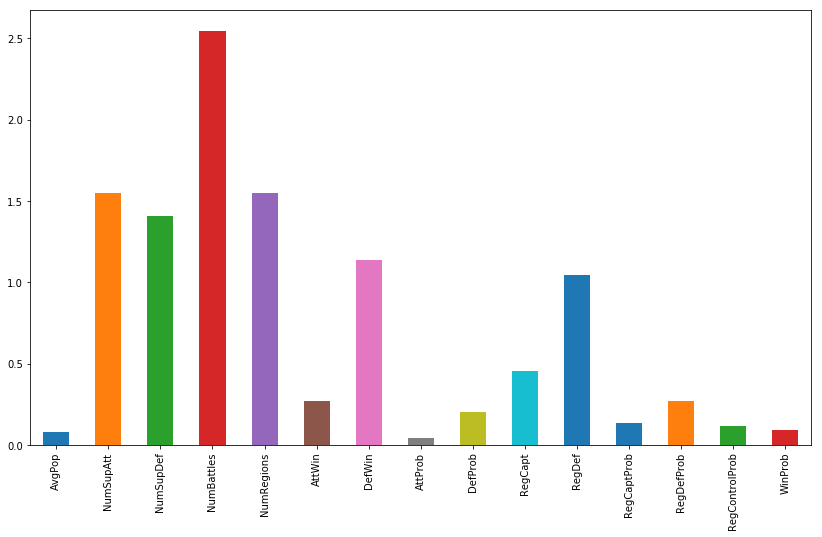

In [61]:
BigHouseProb = BigHouse.drop('ArmyAtt',axis=1)
BigHouseProb = BigHouseProb.drop('ArmyDef',axis=1)
BigHouseProb = BigHouseProb.drop('NumChar',axis=1)
BigHouseProb = BigHouseProb.drop('NumNoble',axis=1)

#histogram of the Big House Probabilities
BigHouseProb.mean().plot(kind='bar', figsize=(14,8));

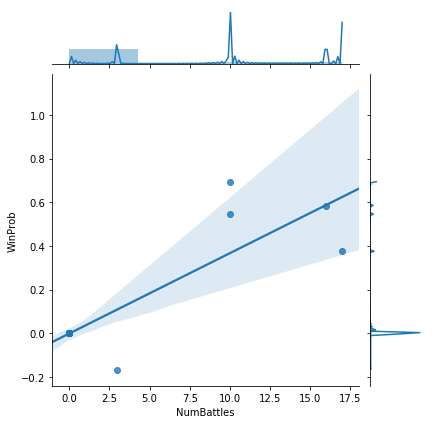

In [62]:
sns.jointplot(x="NumBattles", y="WinProb", data=BigHouse, kind='reg');

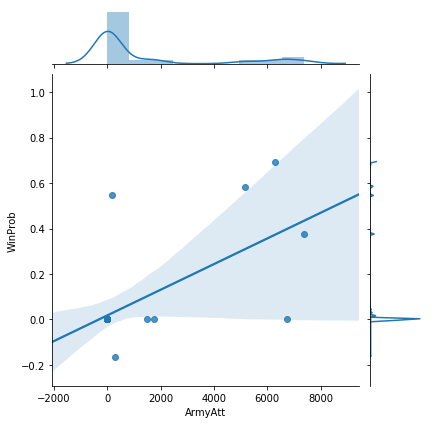

In [63]:
sns.jointplot(x="ArmyAtt", y="WinProb", data=BigHouse, kind='reg');

In [64]:
###### Prediction Tools #######

In [65]:
X = House[['NumBattles','ArmyAtt']]
y = House['WinProb']

In [66]:
reg = DecisionTreeRegressor()
reg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [67]:
reg.score(X,y)

1.0

In [68]:
dot_data = export_graphviz(reg, out_file = None, feature_names = X.columns, class_names = 'WinProb', filled = True)

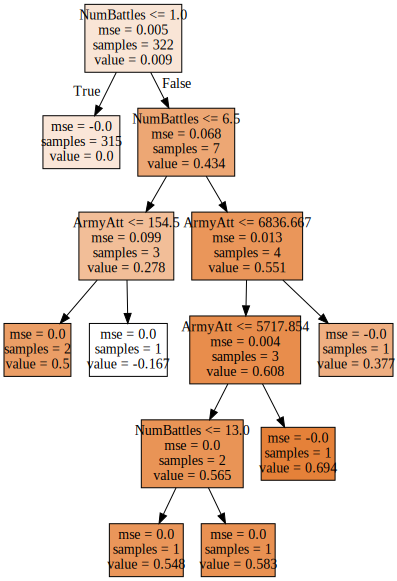

In [69]:
graphviz.Source(dot_data)